## Alchemix Question 25: Investigating Who Is Leaving From the Alchemix Farming Pools

Authors: AGS, dtradke

Date: 2021-04-26

In [1]:
## Import useful libraries and modules
import urllib.request as rq
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Total Exits and Withdrawals

We must first import the raw data from the SQL query. All transfers from the staking pools' address:'0xab8e74017a8cc7c15ffccd726603790d26d7deca' from the past 7 days are queried to see who is withdrawing money/exiting the pool. The "API" button was then selected, and the url copied to feed into this notebook. 

In [479]:
## Function to read data provided by SQL query "API" link
def loadData(url):
    try:
        dataset = rq.urlopen(url)
        dataset = dataset.read()
        dataset = json.loads(dataset)
    except Exception as e:
        print('Unable to get data from flipsidecrypto API. Check the URL below: \n{}'.format(url))
    return dataset

url = "https://api.flipsidecrypto.com/api/v2/queries/5835efdb-5f6a-4d02-9611-17252c1ab2cb/data/latest"
dataset = loadData(url)


In [480]:
df = pd.DataFrame(dataset) # Imported data is a list of dictionaries. This is easily converted to a dataframe

In [481]:
len(df)

1154

In [482]:
unique_addresses = df.TO_ADDRESS.unique()
len(df.TO_ADDRESS.unique())

864

We see that there were 1144 withdrawals/exits in the past week; however, only 864 unique addresses withdrew/exitted, meaning some addresses are making multiple withdrawals, as would be expected. 

We now split the withdrawals/exits into separate dataframes for each pool. This then allows us to fill the "AMOUNT_USD" column with the equivalent USD amount, which allows for easy comparison between the pools. 

In [485]:
ALCX_df = df[df["SYMBOL"] == "ALCX"]
alUSD_df = df[df["SYMBOL"] == "alUSD"]
alUSD_df.loc[:,"AMOUNT_USD"] = alUSD_df["AMOUNT"]
SLP_df = df[df["SYMBOL"] == "ALCX-ETH SLP"]
SLP_df.loc[:,"AMOUNT_USD"] = 3750*SLP_df["AMOUNT"]
CRV_df = df[df["SYMBOL"] == "alUSD3CRV"]
CRV_df.loc[:,"AMOUNT_USD"] = CRV_df["AMOUNT"]

Once the equivalent USD amounts are all filled, we can re-combine the dataframes. We then combine all exits/withdrawals coming from a single address by summing their values. This gives a total amount withdrawn by each unique address over the past week. Sorting and displaying the resulting data shows the five smallest withdrawers (note that this list will not include accounts that did not make any withdrawals/exits over this period). 

In [487]:
big_df = pd.concat([ALCX_df,alUSD_df, SLP_df, CRV_df])
sorted_series = big_df.groupby("TO_ADDRESS")["AMOUNT_USD"].sum().sort_values()

We can sum the entire list to obatin the total amount withdrawn in the past week.

In [201]:
sum(sorted_series)

254610036.1429535

 We see that there has been a little more than 250M USD withdrawn in the past 7 days. This corresponds to a daily average of roughly 36M USD withdrawn. 

## Identifying the Biggest Withdrawers

look at the 10 addresses withdrawing the most over this time period. 

In [185]:
top_10_addresses = list(sorted_series.keys()[-10:])
top_10_values = list(sorted_series.values[-10:])

In [488]:
top_10_values.append(sum(sorted_series) - sum(top_10_values))
top_10_addresses.append('Other')

These can be visualized in a pie chart. 

<function matplotlib.pyplot.show(*args, **kw)>

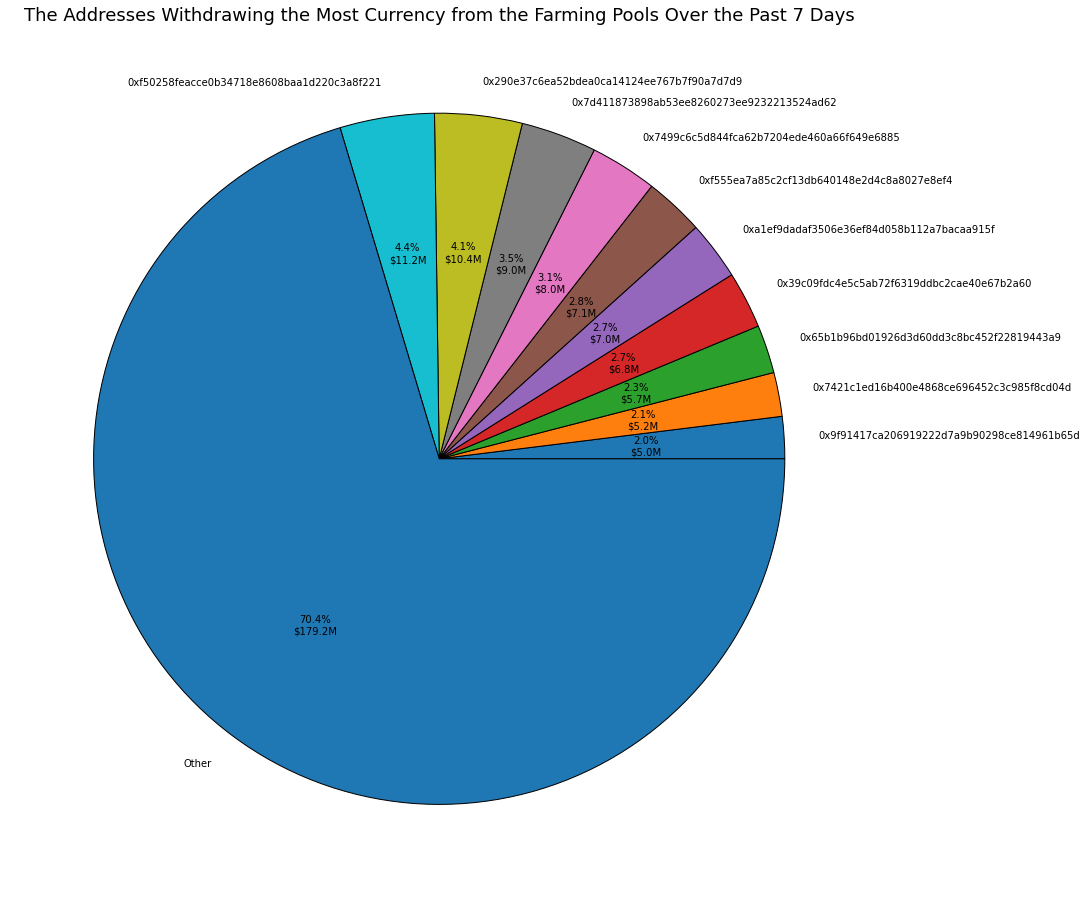

In [241]:
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    absolute_M = absolute/1000000
    return "{:.1f}%\n${:.1f}M".format(pct, (absolute_M))

fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
ax.pie(top_10_values, labels=top_10_addresses, autopct=lambda pct: func(pct,top_10_values), wedgeprops={'edgecolor': 'black'})
ax.set_title("The Addresses Withdrawing the Most Currency from the Farming Pools Over the Past 7 Days", fontsize=18)
plt.show

We can see that the top 10 withdrawers account for roughly 30% of total amount withdrawn in the past week, with the biggest withdrawer accounting for 4.4%. 

## Looking Deeper Into the Biggest Withdrawers

### The Number 1 Withdrawer

We can now look at the other holdings and activity of the top addresses, starting with the largest withdrawer: '0xf50258feacce0b34718e8608baa1d220c3a8f221'. By querying all events from or to this wallet address, we can see their activity over the last 7 days. We first import the entire dataset, but we are only interested in the transfers involving the farming pool tokens, because these are the ones that can be withdrawn from the pools.

In [405]:
url = "https://api.flipsidecrypto.com/api/v2/queries/5835efdb-5f6a-4d02-9611-17252c1ab2cb/data/latest"
dataset = loadData(url)
user1_act = pd.DataFrame(dataset)

cols = ["AMOUNT", "AMOUNT_USD", "BLOCK_TIMESTAMP", "CONTRACT_ADDRESS", "EVENT_NAME", "EVENT_TYPE", "FROM_ADDRESS", "FROM_ADDRESS_NAME", 
       "FROM_LABEL", "FROM_LABEL_SUBTYPE", "FROM_LABEL_TYPE","ORIGIN_FUNCTION_NAME", "SYMBOL", "TO_ADDRESS", "TO_ADDRESS_NAME", "TO_LABEL", "TO_LABEL_SUBTYPE", "TO_LABEL_TYPE", "TX_ID"]
user1_act = user1_act[cols] # Keep only the relevant columns to limit clutter

## Populate the USD Equivalent Value column for all transfers to enable direct comparison
ALCX1_act = user1_act[user1_act["SYMBOL"] == "ALCX"]
alUSD1_act = user1_act[user1_act["SYMBOL"] == "alUSD"]
alUSD1_act.loc[:,"AMOUNT_USD"] = alUSD1_act["AMOUNT"]
SLP1_act = user1_act[user1_act["SYMBOL"] == "ALCX-ETH SLP"]
SLP1_act.loc[:,"AMOUNT_USD"] = 3750*SLP1_act["AMOUNT"]
CRV1_act = user1_act[user1_act["SYMBOL"] == "alUSD3CRV"]
CRV1_act.loc[:,"AMOUNT_USD"] = CRV1_act["AMOUNT"]
comb1_act = pd.concat([ALCX1_act, alUSD1_act, SLP1_act, CRV1_act])
comb1_act = comb1_act.sort_values("BLOCK_TIMESTAMP", ascending=False)

The resulting dataframe containts all transfers to or from this address, we now filter to see only the outgoing transfers from this address. These are the events that will tell us where this user is sending their funds (this could have been done in the original SQL query; however all data was kept initially to allow for preliminary exploration).

In [406]:
user1_out = comb1_act[comb1_act["FROM_ADDRESS"] == "0xf50258feacce0b34718e8608baa1d220c3a8f221"]
user1_out.insert(0, "ID_NAME", np.zeros(len(user1_out)))
for i in range(len(user1_out["ID_NAME"])):
    user1_out.iloc[i,0] = str(user1_out.iloc[i,16]) + " " + str(user1_out.iloc[i,15])
    if user1_out.iloc[i,0] == "None None":
        user1_out.iloc[i,0] = user1_out.iloc[i,14]

We have also added a new column titled "ID_NAME" which will provide a unique identification name for the transfer destinations. If human-readable address labels or names exist, they are concatenated to form the "ID_NAME". If they do not exist for a destination address, the full hexadecimal address is used. We then combine the total value of funds transfered to each address over the past 7 days, so addresses are not repeated. 

In [407]:
user1_sorted = user1_out.groupby("ID_NAME")["AMOUNT_USD"].sum().sort_values()

We can plot the the amounts this user has sent to various addresses over the past 7 days in a bar chart, again converting all values to USD to enable direct comparison. 

<function matplotlib.pyplot.show(*args, **kw)>

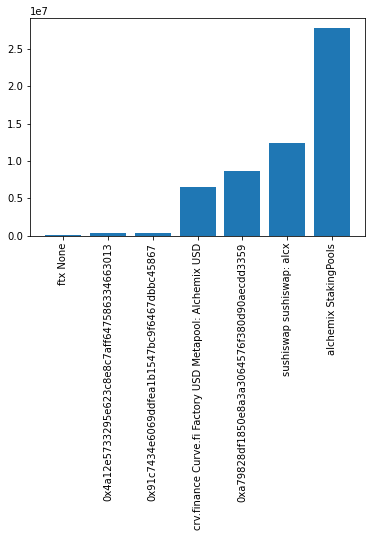

In [420]:
# fig1 = plt.figure()
# ax1 = fig1.add_axes([0,0,3,3])
plt.bar(user1_sorted.keys(), user1_sorted)
#plt.set_title("Transfer Destinations of Biggest Withdrawer Over the Past 7 Days", fontsize=18)
plt.xticks(rotation='vertical')
plt.show

As can be seen, while this user is the biggest withdrawer, they primarily deposit these currencies back into the farming pools, and have in fact deposited much more into the staking pools than they have taken out over the past week. When investigating the deposits and withdrawals in chronological order, it was seen that they frequently alternated deposits and withdrawals, across the four farming pools. This indicates that the large amounts withdrawn from the pools do not mean that this user is leaving permanently, only that they are frequently moving funds into, out of, and between the pools. Beyond deposits into the farming pools, this user swaps large quantities of the farming pool tokens into other types of tokens, or into USD. Finally, we see that they also transfer large quanitities to other wallet addresses that do not have listed labels or names. This is likely another wallet owned by the same user, and the outgoing transfers indicate that they are sending funds between these wallets. 

We now look at the tokens and funds currently in this wallet to see what they are holding presently. The ERC20_balances for this user are queried and imported into a dataframe here

In [412]:
url = "https://api.flipsidecrypto.com/api/v2/queries/a255c7eb-ced5-407b-8ffd-921bff27e5cf/data/latest"
dataset = loadData(url)
user1_bal = pd.DataFrame(dataset)

We take the most recent balances, and populate the "USD_AMOUNT" column to enable direct comparison. 

In [413]:
user1_bal = user1_bal[user1_bal["BALANCE_DATE"] == "2021-04-26T00:00:00Z"]
for i in range(len(user1_bal["SYMBOL"])):
    if user1_bal.iloc[i,10] == "alUSD":
        user1_bal.iloc[i,1] = user1_bal.iloc[i,2]
    elif user1_bal.iloc[i,10] == "alUSD3CRV":
        user1_bal.iloc[i,1] = user1_bal.iloc[i,2]
    elif user1_bal.iloc[i,10] == "ALCX-ETH SLP":
        user1_bal.iloc[i,1] = 3750*user1_bal.iloc[i,2]    

We can plot the quantities of the various tokens owned as of the most recent balance in the ERC20_balances table:

<function matplotlib.pyplot.show(*args, **kw)>

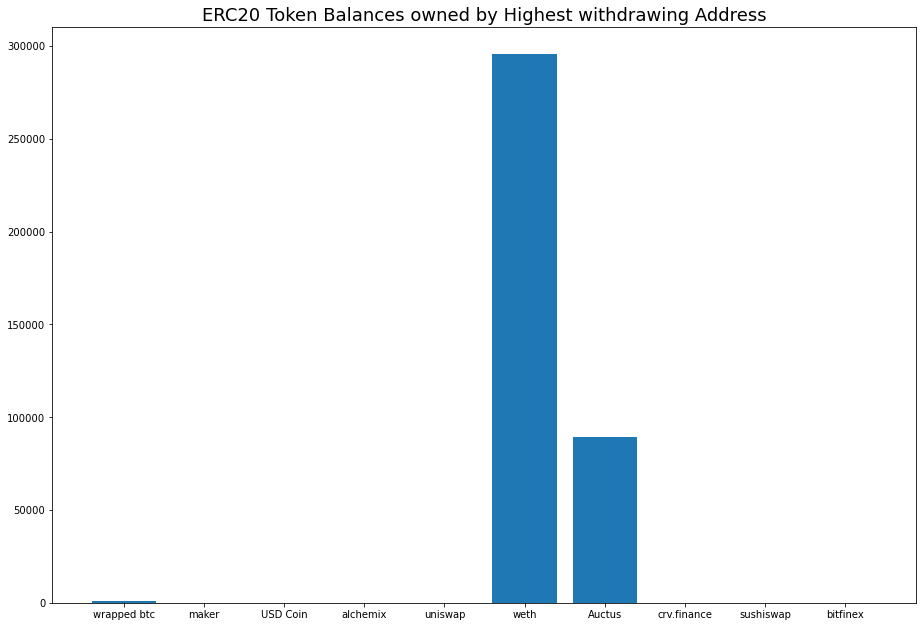

In [414]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,2,2])
ax1.bar(user1_bal["CONTRACT_LABEL"], user1_bal["AMOUNT_USD"])
ax1.set_title("ERC20 Token Balances owned by Highest withdrawing Address", fontsize=18)
plt.show

As can be seen above, there are several tokens that the wallet tracks the balance of, but that presently have a balance of 0. These were included in the plot as they indicate that this user does trade in these tokens, even if they do not presently own any. The main tokens currently owned by this user are Auctus, wrapped ether, and wrapped bitcoin. It should be noted however; that the quantities of these tokens currently in this wallet are quite small compared to the amounts being deposited into and withdrawn from the farming pools, indicating that this user does not tend to hold the bulk of its assets in this wallet. They either have the bulk of their assets invested/staked in various pools, or keep the bulk of their funds in another wallet. 

### The Number 2 Withdrawer

We repeat the same process for the address withdrawing the second most from the farming pools: '0x290e37c6ea52bdea0ca14124ee767b7f90a7d7d9'. 

In [489]:
url = "https://api.flipsidecrypto.com/api/v2/queries/5835efdb-5f6a-4d02-9611-17252c1ab2cb/data/latest"
dataset = loadData(url)
user2_act = pd.DataFrame(dataset)

cols = ["AMOUNT", "AMOUNT_USD", "BLOCK_TIMESTAMP", "CONTRACT_ADDRESS", "EVENT_NAME", "EVENT_TYPE", "FROM_ADDRESS", "FROM_ADDRESS_NAME", 
       "FROM_LABEL", "FROM_LABEL_SUBTYPE", "FROM_LABEL_TYPE","ORIGIN_FUNCTION_NAME", "SYMBOL", "TO_ADDRESS", "TO_ADDRESS_NAME", "TO_LABEL", "TO_LABEL_SUBTYPE", "TO_LABEL_TYPE", "TX_ID"]
user2_act = user2_act[cols] # Keep only the relevant columns to limit clutter

## Populate the USD Equivalent Value column for all transfers to enable direct comparison
ALCX2_act = user2_act[user2_act["SYMBOL"] == "ALCX"]
alUSD2_act = user2_act[user2_act["SYMBOL"] == "alUSD"]
alUSD2_act.loc[:,"AMOUNT_USD"] = alUSD2_act["AMOUNT"]
SLP2_act = user2_act[user2_act["SYMBOL"] == "ALCX-ETH SLP"]
SLP2_act.loc[:,"AMOUNT_USD"] = 3750*SLP2_act["AMOUNT"]
CRV2_act = user2_act[user2_act["SYMBOL"] == "alUSD3CRV"]
CRV2_act.loc[:,"AMOUNT_USD"] = CRV2_act["AMOUNT"]
comb2_act = pd.concat([ALCX2_act, alUSD2_act, SLP2_act, CRV2_act])
comb2_act = comb2_act.sort_values("BLOCK_TIMESTAMP", ascending=False)

In [428]:
user2_out = comb2_act[comb2_act["FROM_ADDRESS"] == "0x290e37c6ea52bdea0ca14124ee767b7f90a7d7d9"]
user2_out.insert(0, "ID_NAME", np.zeros(len(user2_out)))
for i in range(len(user2_out["ID_NAME"])):
    user2_out.iloc[i,0] = str(user2_out.iloc[i,16]) + " " + str(user2_out.iloc[i,15])
    if user2_out.iloc[i,0] == "None None":
        user2_out.iloc[i,0] = user2_out.iloc[i,14]

In [429]:
user2_sorted = user2_out.groupby("ID_NAME")["AMOUNT_USD"].sum().sort_values()
user2_sorted

ID_NAME
0x1bd435f3c054b6e901b7b108a0ab7617c808677b    2.264012e+05
sushiswap sushiswap: alcx                     3.559099e+05
genesis genesis                               5.089233e+05
0xa79828df1850e8a3a3064576f380d90aecdd3359    1.040644e+07
alchemix StakingPools                         1.470372e+07
Name: AMOUNT_USD, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

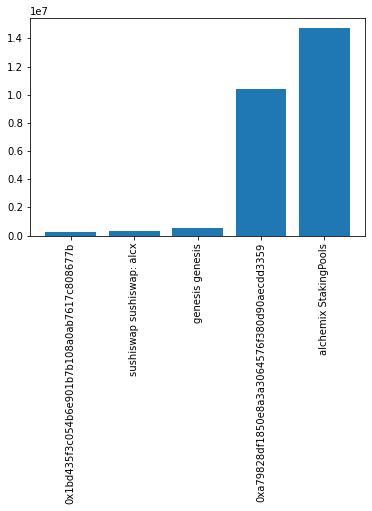

In [431]:
# fig1 = plt.figure()
# ax1 = fig1.add_axes([0,0,3,3])
plt.bar(user2_sorted.keys(), user2_sorted)
#plt.set_title("Transfer Destinations of 2nd Biggest Withdrawer Over the Past 7 Days", fontsize=18)
plt.xticks(rotation='vertical')
plt.show

We see once again that the biggest destination for the transfers from this account is back into the farming pools, and once again they have actually deposited more in the past week than the have withdrawn. The other primary destination of outgoing transfers from the wallet is another wallet address with no associated name or label, again suggesting that it is most-likely another wallet owned by the same user. 

In [436]:
url = "https://api.flipsidecrypto.com/api/v2/queries/a255c7eb-ced5-407b-8ffd-921bff27e5cf/data/latest"
dataset = loadData(url)
user2_bal = pd.DataFrame(dataset)

In [438]:
user2_bal = user2_bal[user2_bal["BALANCE_DATE"] == "2021-04-26T00:00:00Z"]
for i in range(len(user2_bal["SYMBOL"])):
    if user2_bal.iloc[i,10] == "alUSD":
        user2_bal.iloc[i,1] = user2_bal.iloc[i,2]
    elif user2_bal.iloc[i,10] == "alUSD3CRV":
        user2_bal.iloc[i,1] = user2_bal.iloc[i,2]
    elif user2_bal.iloc[i,10] == "ALCX-ETH SLP":
        user2_bal.iloc[i,1] = 3750*user2_bal.iloc[i,2]    

<function matplotlib.pyplot.show(*args, **kw)>

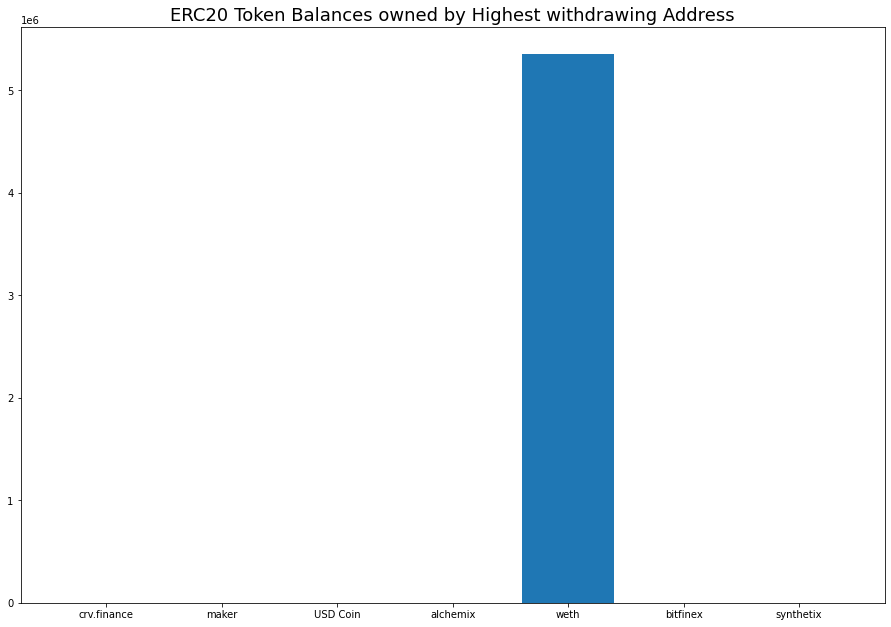

In [439]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,2,2])
ax1.bar(user2_bal["CONTRACT_LABEL"], user2_bal["AMOUNT_USD"])
ax1.set_title("ERC20 Token Balances owned by Highest withdrawing Address", fontsize=18)
plt.show

It can be seen that the only token presently in this wallet is wrapped ether; however, once again, the other token balances tracked by the wallet that are currently at 0, suggest that this user does own these tokens at times. 

### The Number 3 Withdrawer

We repeat the same process for the address withdrawing the third most from the farming pools: '0x7d411873898ab53ee8260273ee9232213524ad62'.

In [440]:
url = "https://api.flipsidecrypto.com/api/v2/queries/5835efdb-5f6a-4d02-9611-17252c1ab2cb/data/latest"
dataset = loadData(url)
user3_act = pd.DataFrame(dataset)

cols = ["AMOUNT", "AMOUNT_USD", "BLOCK_TIMESTAMP", "CONTRACT_ADDRESS", "EVENT_NAME", "EVENT_TYPE", "FROM_ADDRESS", "FROM_ADDRESS_NAME", 
       "FROM_LABEL", "FROM_LABEL_SUBTYPE", "FROM_LABEL_TYPE","ORIGIN_FUNCTION_NAME", "SYMBOL", "TO_ADDRESS", "TO_ADDRESS_NAME", "TO_LABEL", "TO_LABEL_SUBTYPE", "TO_LABEL_TYPE", "TX_ID"]
user3_act = user3_act[cols] # Keep only the relevant columns to limit clutter

## Populate the USD Equivalent Value column for all transfers to enable direct comparison
ALCX3_act = user3_act[user3_act["SYMBOL"] == "ALCX"]
alUSD3_act = user3_act[user3_act["SYMBOL"] == "alUSD"]
alUSD3_act.loc[:,"AMOUNT_USD"] = alUSD3_act["AMOUNT"]
SLP3_act = user3_act[user3_act["SYMBOL"] == "ALCX-ETH SLP"]
SLP3_act.loc[:,"AMOUNT_USD"] = 3750*SLP3_act["AMOUNT"]
CRV3_act = user3_act[user3_act["SYMBOL"] == "alUSD3CRV"]
CRV3_act.loc[:,"AMOUNT_USD"] = CRV3_act["AMOUNT"]
comb3_act = pd.concat([ALCX3_act, alUSD3_act, SLP3_act, CRV3_act])
comb3_act = comb3_act.sort_values("BLOCK_TIMESTAMP", ascending=False)

In [441]:
user3_out = comb3_act[comb3_act["FROM_ADDRESS"] == "0x7d411873898ab53ee8260273ee9232213524ad62"]
user3_out.insert(0, "ID_NAME", np.zeros(len(user3_out)))
for i in range(len(user3_out["ID_NAME"])):
    user3_out.iloc[i,0] = str(user3_out.iloc[i,16]) + " " + str(user3_out.iloc[i,15])
    if user3_out.iloc[i,0] == "None None":
        user3_out.iloc[i,0] = user3_out.iloc[i,14]

In [490]:
user3_sorted = user3_out.groupby("ID_NAME")["AMOUNT_USD"].sum().sort_values()

<function matplotlib.pyplot.show(*args, **kw)>

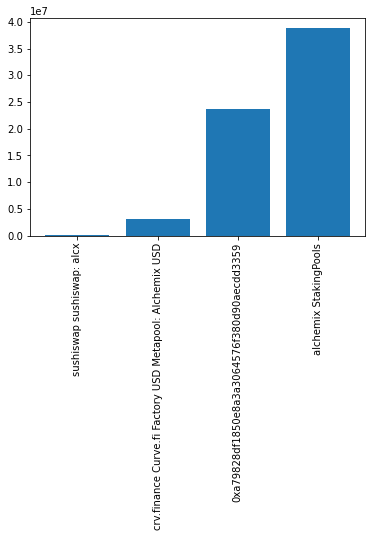

In [443]:
# fig1 = plt.figure()
# ax1 = fig1.add_axes([0,0,3,3])
plt.bar(user3_sorted.keys(), user3_sorted)
#plt.set_title("Transfer Destinations of 2nd Biggest Withdrawer Over the Past 7 Days", fontsize=18)
plt.xticks(rotation='vertical')
plt.show

We see once again that the biggest desitination for outgoing transfers from this address is back into the staking pools, and once again, they have in fact deposited much more than they have withdrawn over the past 7 days. They swap some of their tokens for USD, and transfer many to another wallet address with no listed label or name. Once again, this is likely another wallet owned by the same user. 

In [448]:
url = "https://api.flipsidecrypto.com/api/v2/queries/a255c7eb-ced5-407b-8ffd-921bff27e5cf/data/latest"
dataset = loadData(url)
user3_bal = pd.DataFrame(dataset)

In [452]:
user3_bal = user3_bal[user3_bal["BALANCE_DATE"] == "2021-04-26T00:00:00Z"]
for i in range(len(user3_bal["SYMBOL"])):
    if user3_bal.iloc[i,10] == "alUSD":
        user3_bal.iloc[i,1] = user3_bal.iloc[i,2]
    elif user3_bal.iloc[i,10] == "alUSD3CRV":
        user3_bal.iloc[i,1] = user3_bal.iloc[i,2]
    elif user3_bal.iloc[i,10] == "ALCX-ETH SLP":
        user3_bal.iloc[i,1] = 3750*user3_bal.iloc[i,2]    

<function matplotlib.pyplot.show(*args, **kw)>

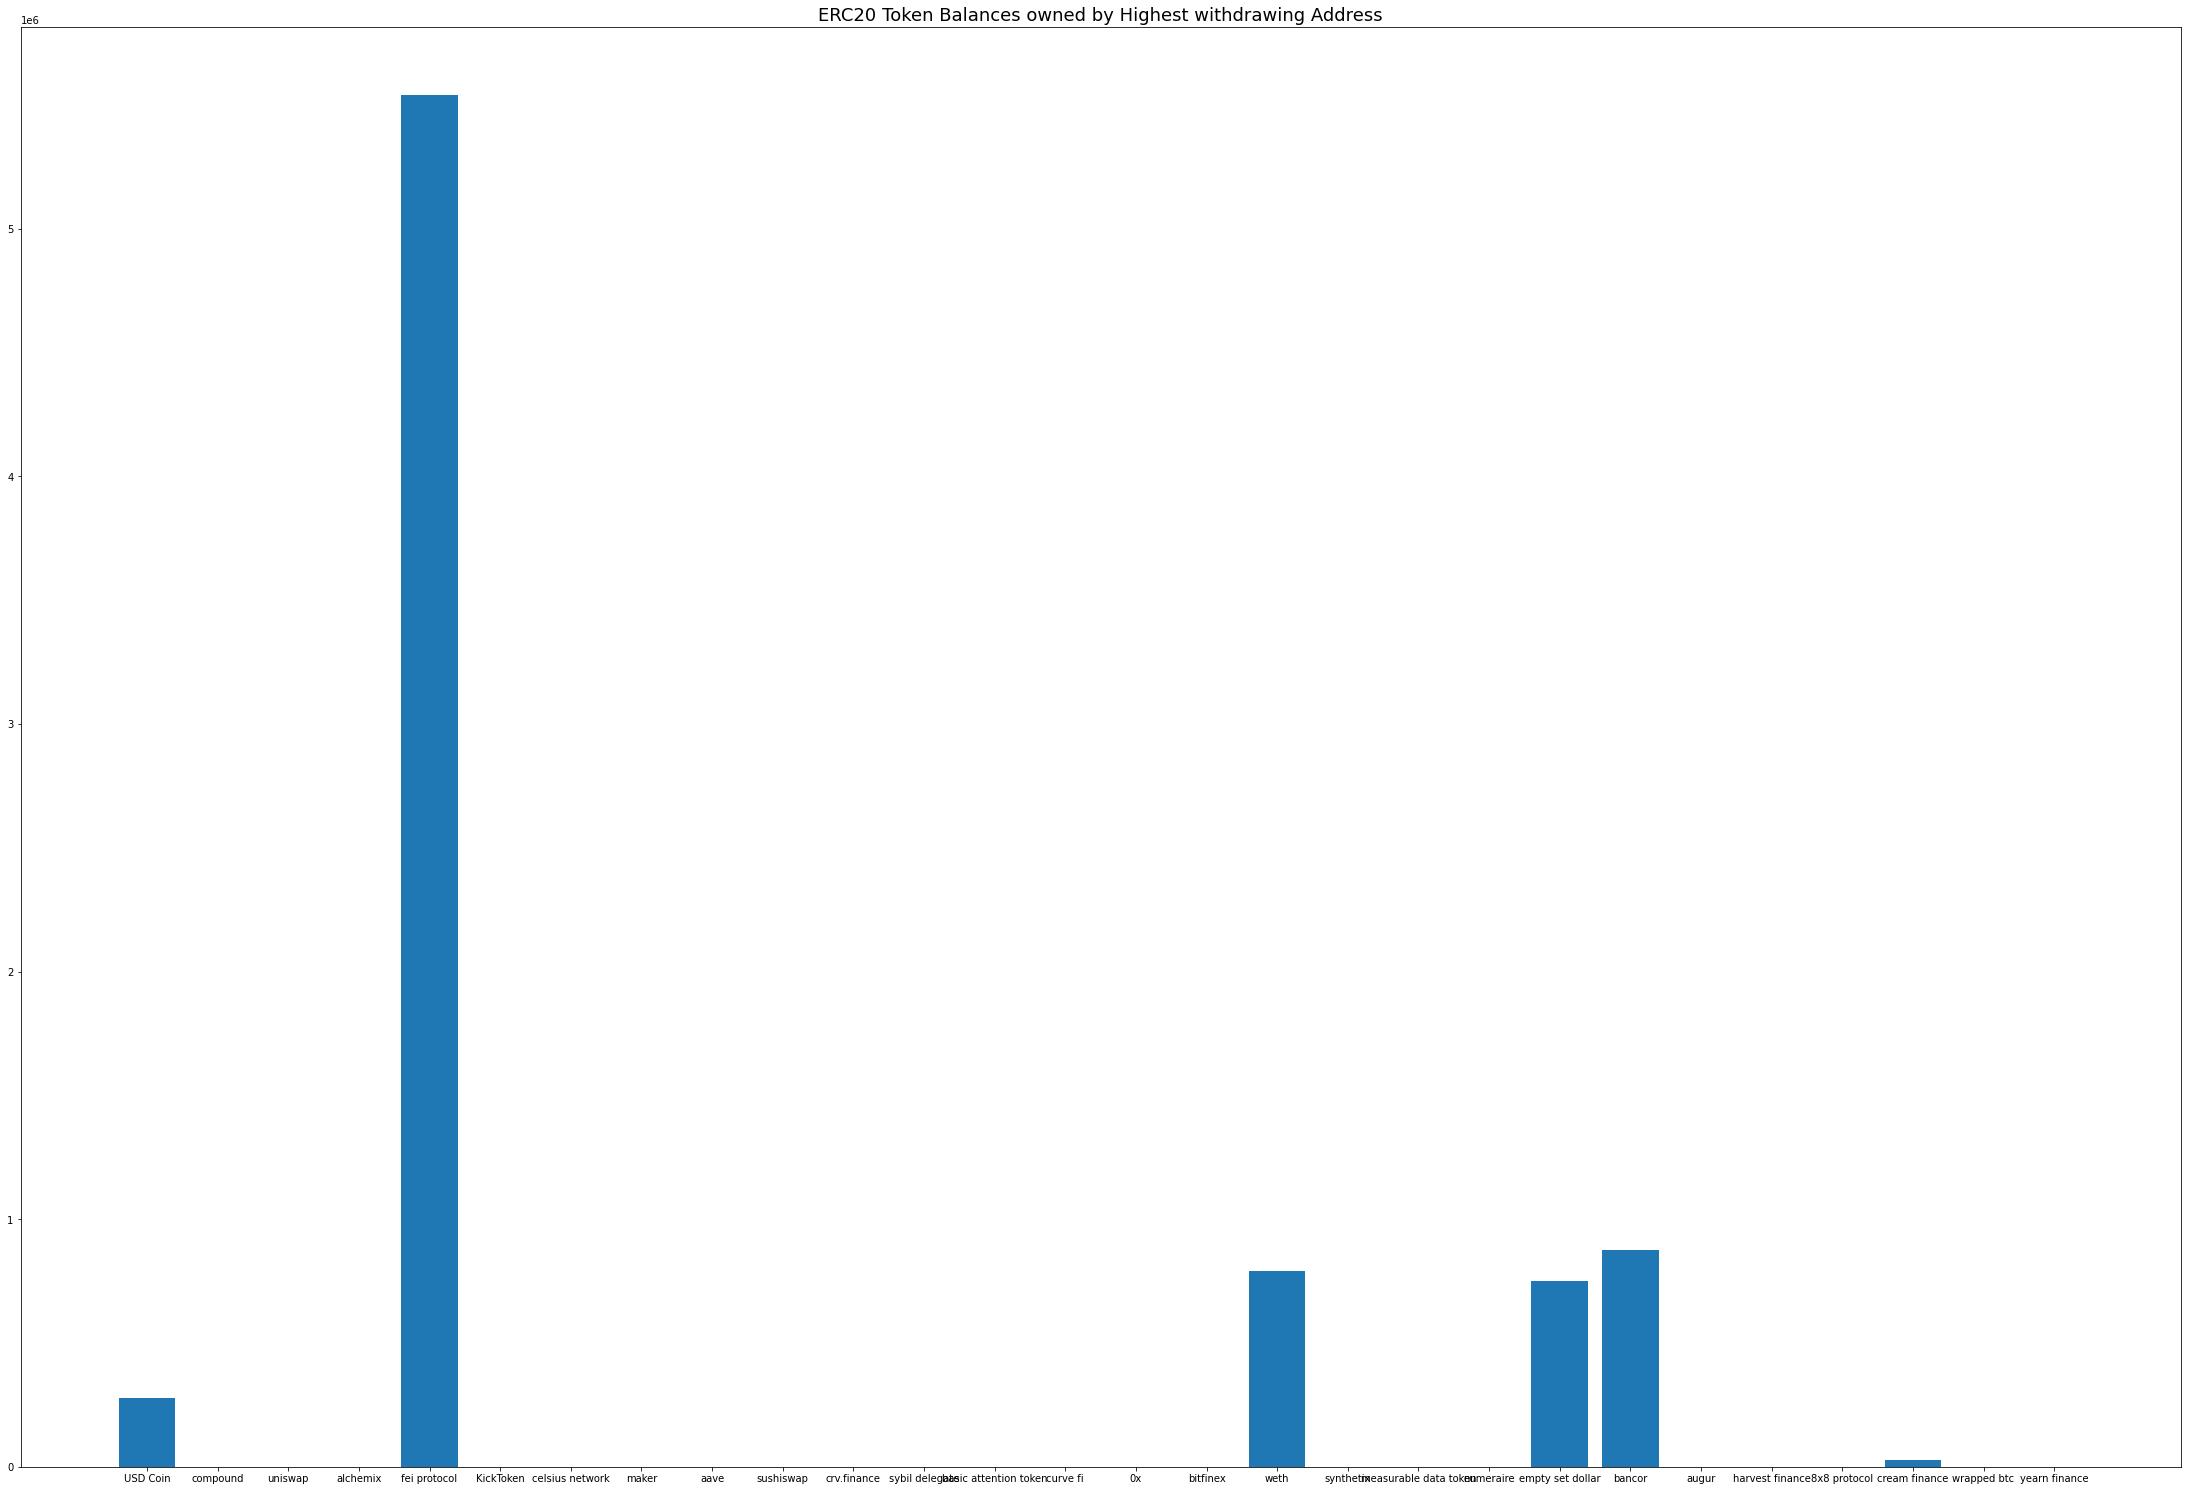

In [455]:
fig3 = plt.figure()
ax3 = fig3.add_axes([0,0,5,5])
ax3.bar(user3_bal["CONTRACT_LABEL"], user3_bal["AMOUNT_USD"])
ax3.set_title("ERC20 Token Balances owned by Highest withdrawing Address", fontsize=18)
plt.show

We can see that this user owns wrapped ether, similar to the other users studied, but also owns large amounts of fei protocol tokens, as well as several other tokens.

### The Number 4 Withdrawer

We repeat the same process for the address withdrawing the fourth most from the farming pools: '0x7499c6c5d844fca62b7204ede460a66f649e6885'.

In [457]:
url = "https://api.flipsidecrypto.com/api/v2/queries/5835efdb-5f6a-4d02-9611-17252c1ab2cb/data/latest"
dataset = loadData(url)
user4_act = pd.DataFrame(dataset)

cols = ["AMOUNT", "AMOUNT_USD", "BLOCK_TIMESTAMP", "CONTRACT_ADDRESS", "EVENT_NAME", "EVENT_TYPE", "FROM_ADDRESS", "FROM_ADDRESS_NAME", 
       "FROM_LABEL", "FROM_LABEL_SUBTYPE", "FROM_LABEL_TYPE","ORIGIN_FUNCTION_NAME", "SYMBOL", "TO_ADDRESS", "TO_ADDRESS_NAME", "TO_LABEL", "TO_LABEL_SUBTYPE", "TO_LABEL_TYPE", "TX_ID"]
user4_act = user4_act[cols] # Keep only the relevant columns to limit clutter

## Populate the USD Equivalent Value column for all transfers to enable direct comparison
ALCX4_act = user4_act[user4_act["SYMBOL"] == "ALCX"]
alUSD4_act = user4_act[user4_act["SYMBOL"] == "alUSD"]
alUSD4_act.loc[:,"AMOUNT_USD"] = alUSD4_act["AMOUNT"]
SLP4_act = user4_act[user4_act["SYMBOL"] == "ALCX-ETH SLP"]
SLP4_act.loc[:,"AMOUNT_USD"] = 3750*SLP4_act["AMOUNT"]
CRV4_act = user4_act[user4_act["SYMBOL"] == "alUSD3CRV"]
CRV4_act.loc[:,"AMOUNT_USD"] = CRV4_act["AMOUNT"]
comb4_act = pd.concat([ALCX4_act, alUSD4_act, SLP4_act, CRV4_act])
comb4_act = comb4_act.sort_values("BLOCK_TIMESTAMP", ascending=False)

In [458]:
user4_out = comb4_act[comb4_act["FROM_ADDRESS"] == "0x7499c6c5d844fca62b7204ede460a66f649e6885"]
user4_out.insert(0, "ID_NAME", np.zeros(len(user4_out)))
for i in range(len(user4_out["ID_NAME"])):
    user4_out.iloc[i,0] = str(user4_out.iloc[i,16]) + " " + str(user4_out.iloc[i,15])
    if user4_out.iloc[i,0] == "None None":
        user4_out.iloc[i,0] = user4_out.iloc[i,14]

In [491]:
user4_sorted = user4_out.groupby("ID_NAME")["AMOUNT_USD"].sum().sort_values()

<function matplotlib.pyplot.show(*args, **kw)>

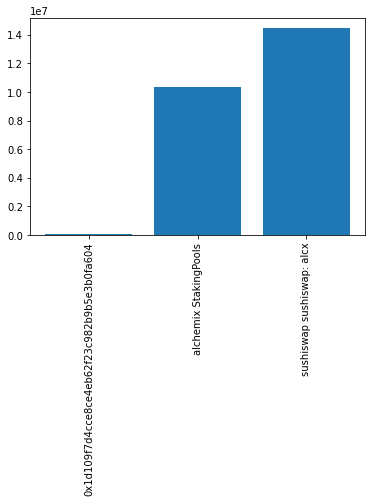

In [462]:
# fig1 = plt.figure()
# ax1 = fig1.add_axes([0,0,3,3])
plt.bar(user4_sorted.keys(), user4_sorted)
#plt.set_title("Transfer Destinations of 2nd Biggest Withdrawer Over the Past 7 Days", fontsize=18)
plt.xticks(rotation='vertical')
plt.show

We see once again that this user deposits large quantities back into the staking pools, but in this case they also swap significant quantities to other tokens via sushiswap. 

In [463]:
url = "https://api.flipsidecrypto.com/api/v2/queries/a255c7eb-ced5-407b-8ffd-921bff27e5cf/data/latest"
dataset = loadData(url)
user4_bal = pd.DataFrame(dataset)

In [465]:
user4_bal = user4_bal[user4_bal["BALANCE_DATE"] == "2021-04-26T00:00:00Z"]
for i in range(len(user4_bal["SYMBOL"])):
    if user4_bal.iloc[i,10] == "alUSD":
        user4_bal.iloc[i,1] = user4_bal.iloc[i,2]
    elif user4_bal.iloc[i,10] == "alUSD3CRV":
        user4_bal.iloc[i,1] = user4_bal.iloc[i,2]
    elif user4_bal.iloc[i,10] == "ALCX-ETH SLP":
        user4_bal.iloc[i,1] = 3750*user4_bal.iloc[i,2]    

<function matplotlib.pyplot.show(*args, **kw)>

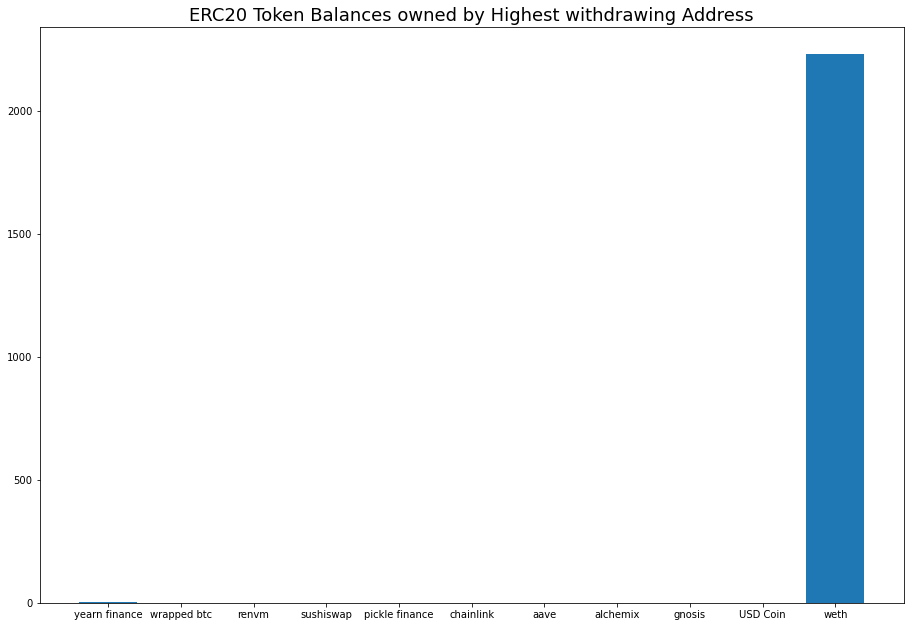

In [468]:
fig4 = plt.figure()
ax4 = fig4.add_axes([0,0,2,2])
ax4.bar(user4_bal["CONTRACT_LABEL"], user4_bal["AMOUNT_USD"])
ax4.set_title("ERC20 Token Balances owned by Highest withdrawing Address", fontsize=18)
plt.show

It can be seen that this user is holding mainly wrapped ether in this wallet; however, the quantity is very small compared to the amounts the user is regularly depositing and withdrawing, suggesting that they likely do not hold the bulk of their assets in this wallet. 

## Overall Conclusions

As could be seen when investigating the four largest withdrawers from the farming pools, these large withdrawers are typically not actually leaving the pool. They are simply users with a high volume of tokens invested, who frequently move their investments into, out of, and between the pools. This results in high volumes being withdrawn, but in all cases, they were in fact depositing more than they were withdrawing from the farming pools over the past 7 days. 